In [4]:
import tensorflow as tf
import os

In [5]:
# this makes sure GPU is allocated on demand not upfront
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Remove bad images

In [6]:
import cv2
import imghdr

In [7]:
# some useful variables
data = os.path.join('data', 'training_set')
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data):
  if image_class == '.ipynb_checkpoints':
    continue

    for image in os.listdir(os.path.join(data, image_class)):

        if image == '.ipynb_checkpoints':
          continue

        image_path = os.path.join(data, image_class, image)

        try:
            tip = imghdr.what(image_path) # gets extension

            if tip not in image_exts:
                print(f'Image not in ext list {image_exts}')
                os.remove(image_path)
        except Exception as e:
            print(f'Issue with image {image_path}')
            os.remove(image_path)

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
# this helps automatically load all the image into a dataset and also the labels as well and it resizes the image to 256 by 256 pixels
data = tf.keras.utils.image_dataset_from_directory(os.path.join('data', 'training_set'), batch_size=200)

Found 8005 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
batch = data_iterator.next()

In [13]:
# data has two parts first part is the images second is the labels
len(batch)

2

In [14]:
# this provides 200 images per batch, resized to 256 by 256 pixels and 3 channels (colored images)
batch[0].shape

(200, 256, 256, 3)

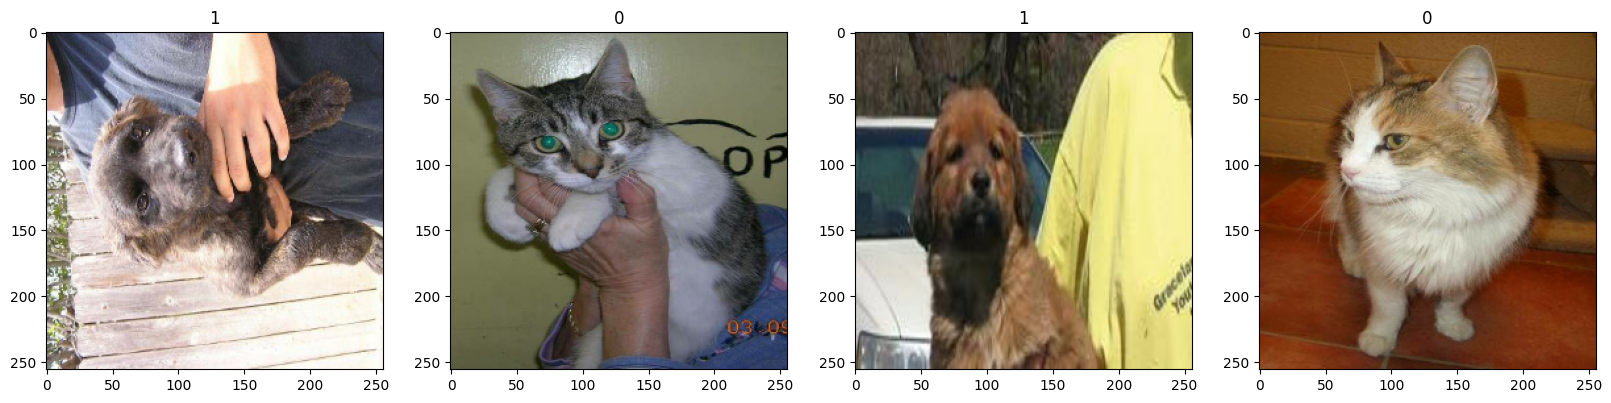

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### from the above you can see that cats are 0 and dogs are 1

## Prepocessing

In [16]:
# scale the data from 0 to 255 to 0 and 1

# x is the image
# y is the labels 

# this function makes sure as new batches come in they are scaled
data = data.map(lambda x, y: (x/255, y))

In [17]:
scaled_data = data.as_numpy_iterator()

In [18]:
batch = scaled_data.next()

In [23]:
batch[0].min()

0.0

In [24]:
batch[0].max()

1.0

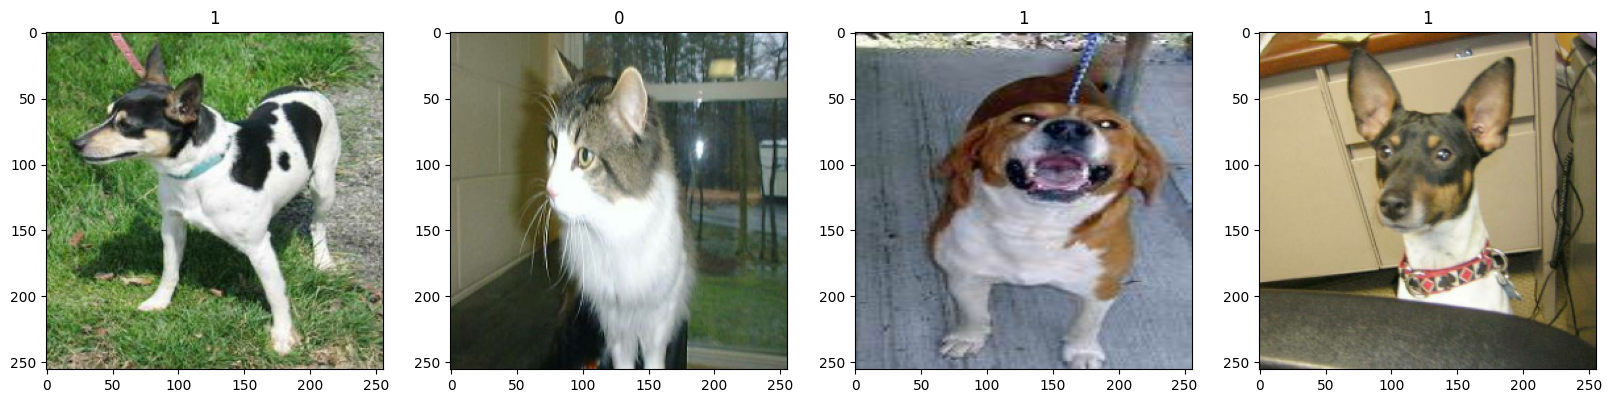

In [19]:
# plotting function
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(float)) 
    # I am changing this to float because since we scaled if we convert to int it will all be 0
    ax[idx].title.set_text(batch[1][idx])

## Deep learning

In [46]:
test_data = tf.keras.utils.image_dataset_from_directory(os.path.join('data', 'test_set'))
test_data = test_data

test_data = test_data.map(lambda x, y: (x/256, y)) # scale it

Found 2023 files belonging to 2 classes.


In [47]:
# since my data is already split up I need to just take all the training data and all the validation data

train = data.take(len(data))
val = test_data.take(int(len(test_data) * .8))
test = test_data.take(int(len(test_data) * .2))

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, RandomFlip, RandomRotation, RandomZoom

In [49]:
# this randomly generates more images from the data by flipping, zooming and rescaling it
data_augmentation = Sequential(
  [
    RandomFlip("horizontal", input_shape=(256, 256, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1)
  ]
)

In [50]:
# first parameter in conv2d represents number of features to extract
# Also this builds the deep neural network
model = Sequential([
  data_augmentation,
  Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)),
  MaxPooling2D(),
  Conv2D(32, (3,3), 1, activation='relu'),
  MaxPooling2D(),
  Conv2D(64, (3,3), 1, activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(0.35),
  Dense(32, activation='relu'),
  Dropout(0.35),
  Dense(1, activation='sigmoid')
])

In [51]:
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [52]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)       

In [53]:
early_stopping = tf.keras.callbacks.EarlyStopping(
        min_delta=0.01,
        patience=5,
        restore_best_weights=True
    )

In [54]:
# auto adjust leanring rate
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

In [55]:
hist = model.fit(
    train,
    epochs=50,
    validation_data=val,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
41/41 [==============================] - 26s 486ms/step - loss: 0.6979 - accuracy: 0.5181 - val_loss: 0.6857 - val_accuracy: 0.5846 - lr: 0.0010
Epoch 2/50
41/41 [==============================] - 22s 498ms/step - loss: 0.6837 - accuracy: 0.5525 - val_loss: 0.6535 - val_accuracy: 0.6342 - lr: 0.0010
Epoch 3/50
41/41 [==============================] - 23s 499ms/step - loss: 0.6636 - accuracy: 0.6106 - val_loss: 0.6375 - val_accuracy: 0.6428 - lr: 0.0010
Epoch 4/50
41/41 [==============================] - 21s 437ms/step - loss: 0.6452 - accuracy: 0.6356 - val_loss: 0.5991 - val_accuracy: 0.6746 - lr: 0.0010
Epoch 5/50
41/41 [==============================] - 22s 490ms/step - loss: 0.6036 - accuracy: 0.6836 - val_loss: 0.6515 - val_accuracy: 0.6023 - lr: 0.0010
Epoch 6/50
41/41 [==============================] - 20s 434ms/step - loss: 0.6911 - accuracy: 0.5404 - val_loss: 0.6840 - val_accuracy: 0.6170 - lr: 0.0010
Epoch 7/50
41/41 [==============================] - 21s 456ms/st

## Analyze performance

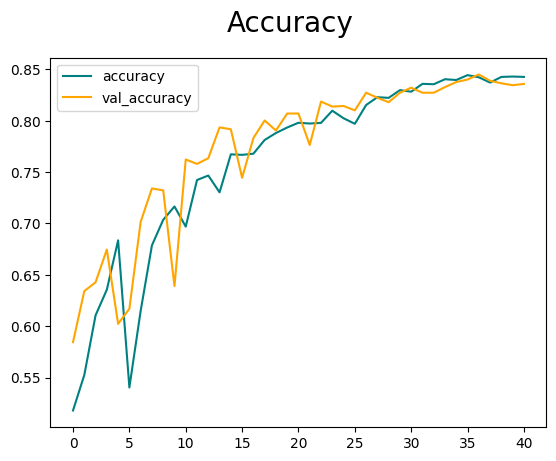

In [61]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [62]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [63]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [64]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 43ms/step


In [65]:
print(f"Precision {pre.result().numpy()}, Recall {re.result().numpy()}, Accuracy: {acc.result().numpy()}")

Precision 0.8495145440101624, Recall 0.8454106450080872, Accuracy: 0.8359375


In [66]:
model.save(os.path.join('models', 'catdogmodel.h5'))